<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/cnn%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download fatemehmehrparvar/lung-disease


Dataset URL: https://www.kaggle.com/datasets/fatemehmehrparvar/lung-disease
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/34.9M [00:00<?, ?B/s]
100% 34.9M/34.9M [00:00<00:00, 1.07GB/s]


In [3]:
import zipfile

zip_path = '/content/lung-disease.zip'
extract_to = 'lung-disease'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping completed!")

Unzipping completed!


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [6]:
img_height, img_width = 64, 64
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/lung-disease/Lung X-Ray Image/Lung X-Ray Image",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/lung-disease/Lung X-Ray Image/Lung X-Ray Image",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 3475 files belonging to 3 classes.
Using 2780 files for training.
Found 3475 files belonging to 3 classes.
Using 695 files for validation.
Classes: ['Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [7]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for batch in dataset:
        imgs, lbls = batch
        images.append(imgs.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(images), np.concatenate(labels)

x_train, y_train = dataset_to_numpy(train_ds)
x_val, y_val = dataset_to_numpy(val_ds)

print("Train shape:", x_train.shape, y_train.shape)
print("Val shape:", x_val.shape, y_val.shape)


Train shape: (2780, 64, 64, 3) (2780,)
Val shape: (695, 64, 64, 3) (695,)


In [8]:
timesteps = img_height
features = img_width * 3

x_train_seq = x_train.reshape(-1, timesteps, features)
x_val_seq = x_val.reshape(-1, timesteps, features)

print("x_train_seq shape:", x_train_seq.shape)


x_train_seq shape: (2780, 64, 192)


In [9]:
inputs = tf.keras.Input(shape=(timesteps, features))

x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(2)(x)

x = tf.keras.layers.LSTM(64)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 62, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 29, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,395 (450.76 KB)

 Trainable params: 115,395 (450.76 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
history = model.fit(x_train_seq, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val_seq, y_val))


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.3402 - loss: 1.1103 - val_accuracy: 0.3554 - val_loss: 1.0972
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3651 - loss: 1.0977 - val_accuracy: 0.3108 - val_loss: 1.0996
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3373 - loss: 1.1012 - val_accuracy: 0.3554 - val_loss: 1.0996
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3629 - loss: 1.0976 - val_accuracy: 0.3554 - val_loss: 1.1009
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3622 - loss: 1.0952 - val_accuracy: 0.3554 - val_loss: 1.1050
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3561 - loss: 1.0997 - val_accuracy: 0.3554 - val_loss: 1.1073
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3447 - loss: 1.1014 - val_accuracy: 0.3554 - val_loss: 1.1062
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3807 - loss: 1.0954 - val_accuracy: 0.3554 - v

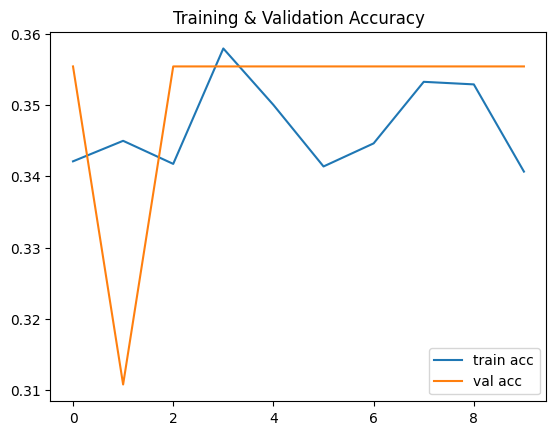

In [12]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()


In [13]:
test_loss, test_acc = model.evaluate(x_val_seq, y_val)
print(f"Validation accuracy: {test_acc:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3290 - loss: 1.1062
Validation accuracy: 0.3554
